In [71]:
#Import two moons
from sklearn.datasets import make_moons
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [72]:
def time_horizon(epsilon=0.002, T=80, rho=7, N=18, device='cpu'):
    """
    Compute the value of t following the formula at the bottom left page 4 of the paper.
    The horizon is flipped compared to the paper because we want to start with the largest value of t.
    epsilon is the minmum std of the noise
    T is the maximum std of the noise
    N is the number of steps
    """
    return torch.tensor([(T ** (1/rho) + (i-1)/(N-1) * (epsilon**(1/rho) - T**(1/rho)))**rho for i in range(1, N+1)]).to(device).type(torch.float32)

class MoonsDataset(Dataset):
    def __init__(self, n_samples, device, noise=0.05):
        X, _ = make_moons(n_samples=n_samples, noise=noise)
        X = torch.tensor(X, dtype=torch.float32)
        self.X = X.to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]
    
    def get_whole_dataset(self):
        return self.X

class DiffusionModel(torch.nn.Module):
    def __init__(self, dim, device, n_layers=3, n_units=256):
        super().__init__()
        self.dim = dim
        self.device = device
        self.n_layers = n_layers
        self.n_units = n_units
        self.linear1 = torch.nn.Sequential(torch.nn.Linear(dim, n_units).to(device), torch.nn.GELU())
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(2 * n_units, n_units).to(device), torch.nn.GELU()) for _ in range(n_layers)])
        self.final_layer = torch.nn.Linear(n_units, dim).to(device)

    def time_embedding(self, timestep_indices, dim, max_period=10000):
        """
        Compute the time embedding
        timesteps: a batch of time steps (1D tensor)
        dim: the dimension of the embedding
        """
        half_dim = dim // 2
        freqs = timestep_indices[:, None] / max_period  ** (2 * torch.arange(half_dim) / dim)
        return torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=1).to(self.device)
        
        
    def forward(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step
        """
        time_embed = self.time_embedding(t, self.n_units).to(self.device) # Compute the time embedding
        y = self.linear1(x) # Apply the first linear layer which differs from the other layers
        
        # Apply the layers
        for layer in self.layers:
            y = torch.cat([y, time_embed], dim=1) # Concatenate the time embedding to the input
            y = layer(y) # Apply the layer
        return self.final_layer(y)
    
def sampling_loop(model, device, batch_size=64, epsilon=0.002, T=80, rho=7, N=18):
    """
    Sample a gaussian noise and iteratively denoise it using the diffusion model.
    """
    x_evolution = [] # List to store the evolution of the denoising process

    Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon

    x_next = torch.randn(batch_size, 2, device=device) * Ts[0] # Sample the latents by sampling a batch of gaussian noise with the maximum std
    x_evolution.append(x_next.detach().cpu().clone()) # Append the initial latents to the list

    # Denoising loop following a simple Euler scheme
    for reversed_idx, (t_cur, t_next) in list(enumerate(zip(Ts[:-1], Ts[1:]))):
        x_cur = x_next # Set the current x to the previous x
        t_idx = len(Ts) - reversed_idx - 1 # Compute the time index by reversing the loop index
        batched_t_idx = torch.full((batch_size,), t_idx, dtype=torch.long) # Create a batched time index
        predicted_x_0_from_x_t = model(x_cur, batched_t_idx) # Predict the denoised image using the model. The time is passed through the index
        euler_step_direction = (predicted_x_0_from_x_t - x_cur) / t_cur # Compute the direction of the Euler step
        x_next = x_cur + (t_cur - t_next) * euler_step_direction # Take an euler step of length t_next - t_cur in the direction euler_step_direction
        
        x_evolution.append(x_next.detach().cpu().clone()) #Append a copy of x_next that is sent to the cpu deatched etc 

    return x_evolution

def training_loop(model, optimizer, dataloader, device, n_epochs=500, epsilon=0.002, T=80, rho=7, N=18):
    """
    Training loop for the diffusion model
    """
    batch_size = dataloader.batch_size # Get the batch size of the dataloader
    Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon
    losses = [] # List to store the losses

    for epoch in range(n_epochs):
        running_loss = 0.0 # Initialize the running loss
        for X in dataloader:
            optimizer.zero_grad() # Zero the gradients

            timesteps = torch.randint(1, len(Ts), (batch_size,)) # Sample random time steps
            
            X_noisy = X + torch.randn_like(X) * Ts[timesteps][:, None].to(device) # Add time-scaled noise to the data
            
            X_hat = model(X_noisy, timesteps) # Predict the denoised image using the model. The time is passed through the index
           
            loss = torch.nn.functional.mse_loss(X_hat, X) # Compute the loss
            loss.backward() # Backward pass
            optimizer.step() # Optimize the model

            running_loss += loss.item() # Add the loss to the running loss
        losses.append(running_loss / len(dataloader)) # Append the average loss to the losses list
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {losses[-1]:.4f}") # Print the average loss

        
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(MSE)")
    plt.show()

    return losses

In [73]:
dataset_size = 16384
training_batch_size = 1024
n_epochs = 200
epsilon = 0.002
T = 80
rho = 7
N = 18
n_units = 512
n_layers = 5
dim = 2
learning_rate = 1e-5
device = "cuda" if torch.cuda.is_available() else "cpu"

Epoch 1/200 - Loss: 0.5746
Epoch 2/200 - Loss: 0.5071
Epoch 3/200 - Loss: 0.5010
Epoch 4/200 - Loss: 0.4999
Epoch 5/200 - Loss: 0.4991
Epoch 6/200 - Loss: 0.4989
Epoch 7/200 - Loss: 0.4982
Epoch 8/200 - Loss: 0.4968
Epoch 9/200 - Loss: 0.4956
Epoch 10/200 - Loss: 0.4932
Epoch 11/200 - Loss: 0.4877
Epoch 12/200 - Loss: 0.4787
Epoch 13/200 - Loss: 0.4590
Epoch 14/200 - Loss: 0.4275
Epoch 15/200 - Loss: 0.3795
Epoch 16/200 - Loss: 0.3526
Epoch 17/200 - Loss: 0.3417
Epoch 18/200 - Loss: 0.3300
Epoch 19/200 - Loss: 0.3300
Epoch 20/200 - Loss: 0.3263
Epoch 21/200 - Loss: 0.3278
Epoch 22/200 - Loss: 0.3226
Epoch 23/200 - Loss: 0.3264
Epoch 24/200 - Loss: 0.3267
Epoch 25/200 - Loss: 0.3240
Epoch 26/200 - Loss: 0.3260
Epoch 27/200 - Loss: 0.3206
Epoch 28/200 - Loss: 0.3248
Epoch 29/200 - Loss: 0.3245
Epoch 30/200 - Loss: 0.3172
Epoch 31/200 - Loss: 0.3222
Epoch 32/200 - Loss: 0.3222
Epoch 33/200 - Loss: 0.3229
Epoch 34/200 - Loss: 0.3196
Epoch 35/200 - Loss: 0.3207
Epoch 36/200 - Loss: 0.3127
E

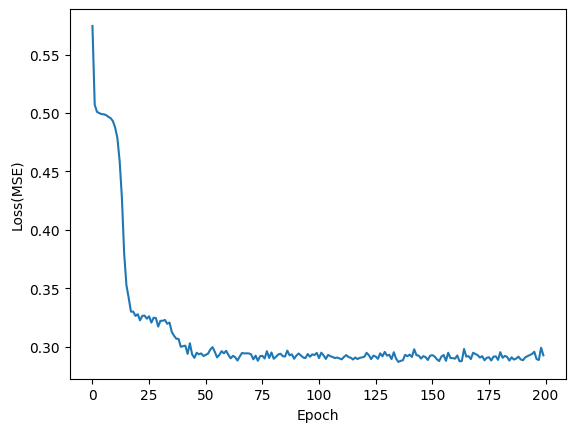

In [74]:
# Create the dataset
dataset = MoonsDataset(dataset_size, device)
dataloader = DataLoader(dataset, batch_size=training_batch_size, shuffle=True)

# Create the model
model = DiffusionModel(dim, device, n_layers, n_units)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
losses = training_loop(model, optimizer, dataloader, device, n_epochs, epsilon, T, rho, N)

In [75]:
x_evolution = sampling_loop(model, device, batch_size=512, epsilon=epsilon, T=T, rho=rho, N=N)

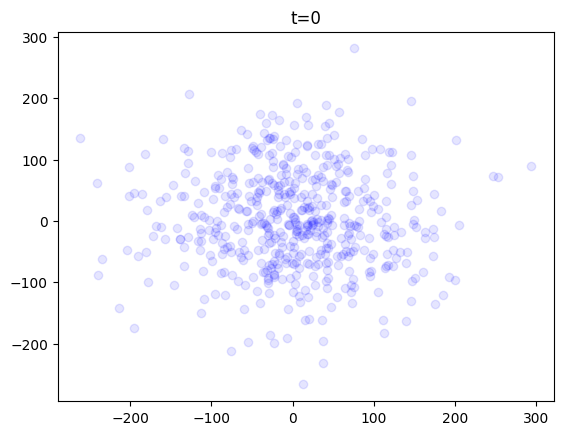

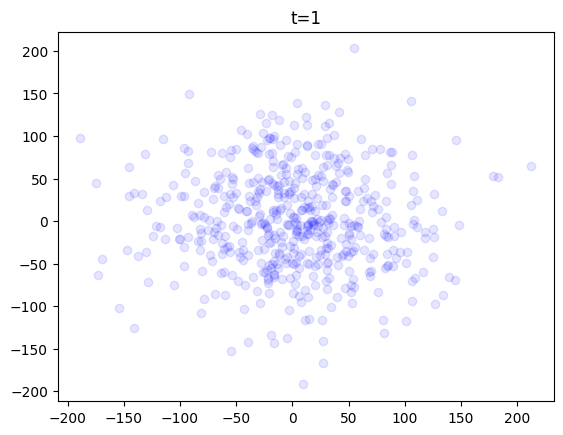

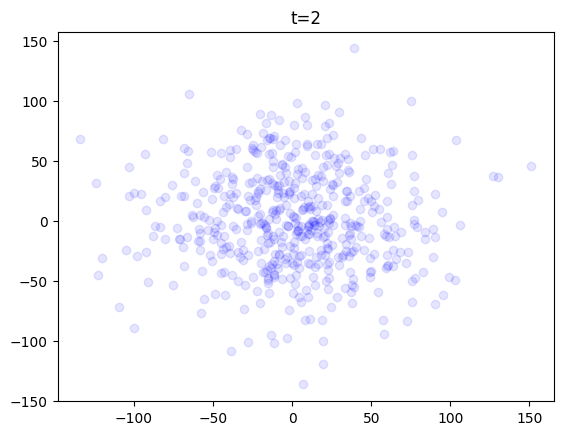

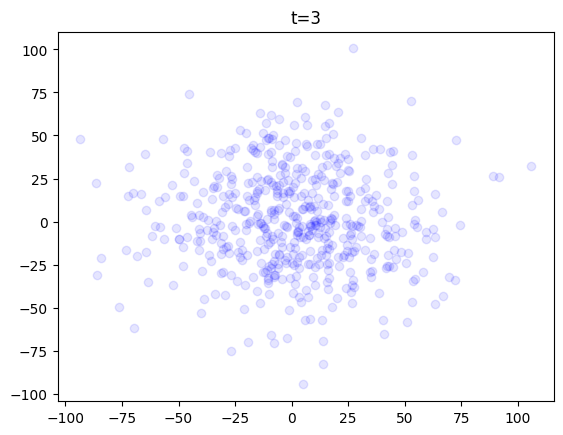

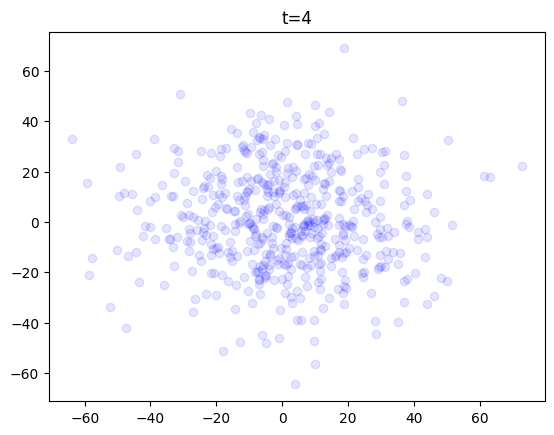

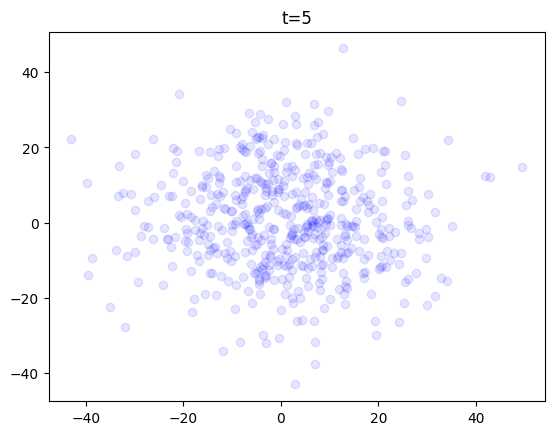

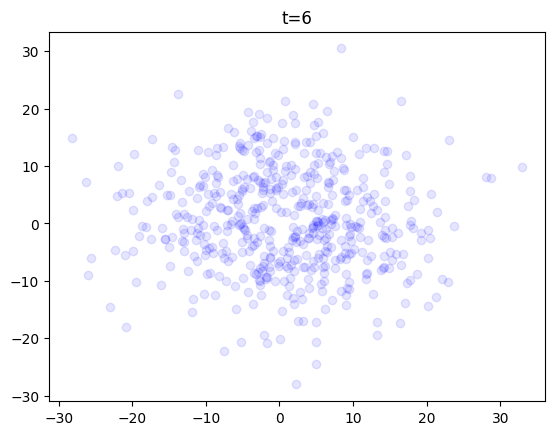

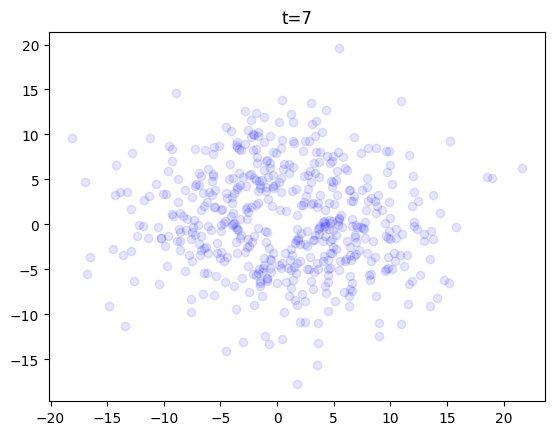

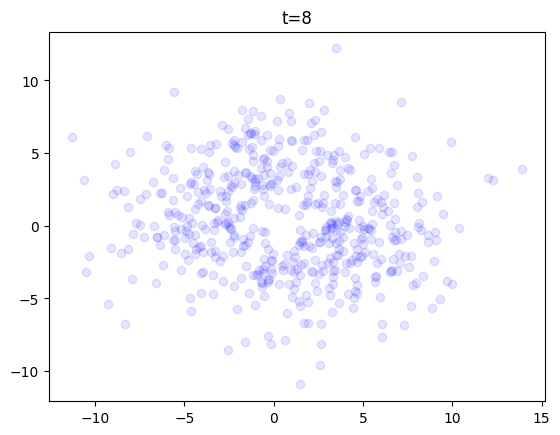

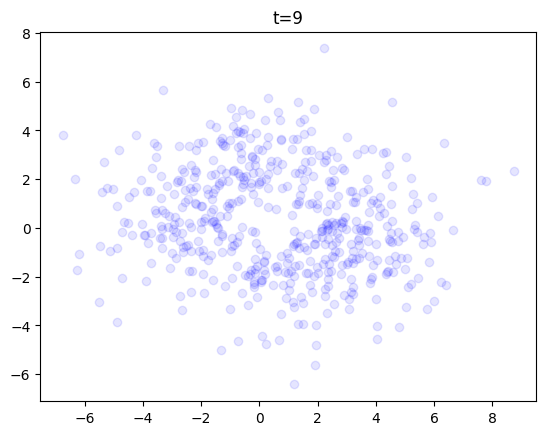

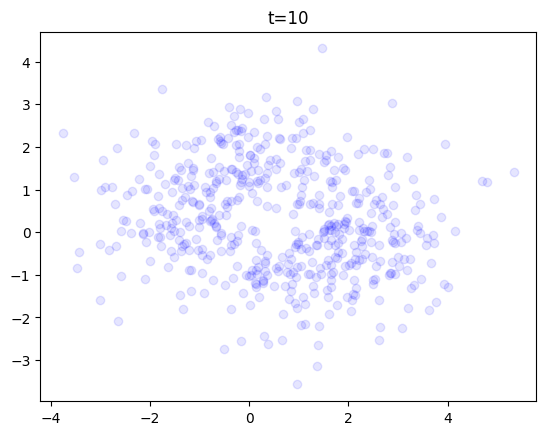

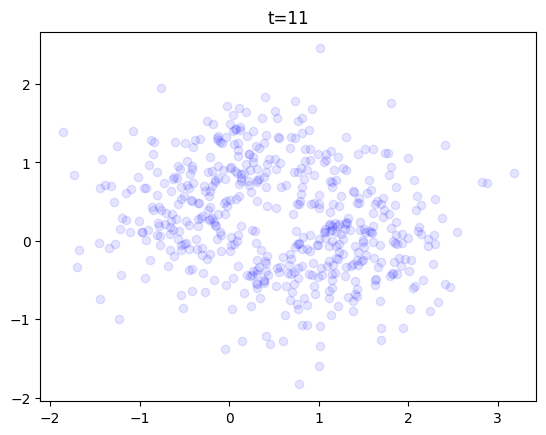

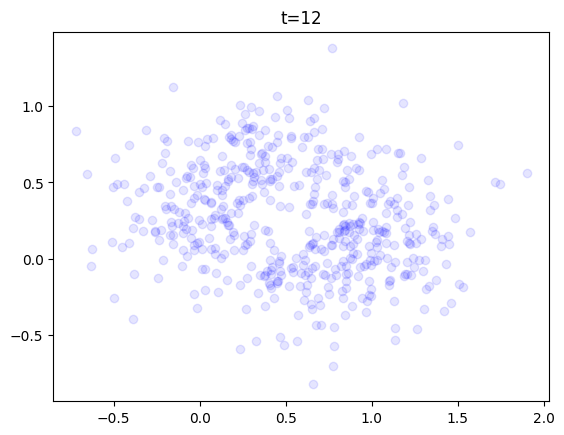

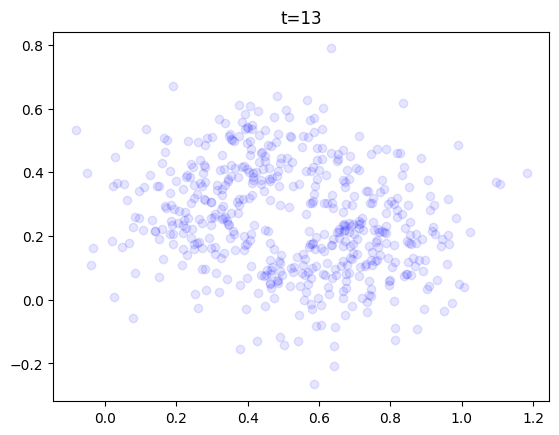

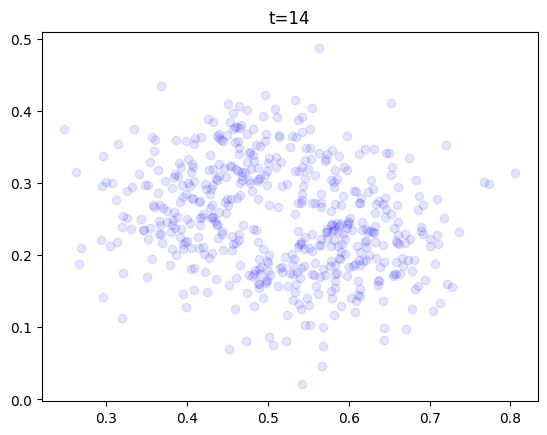

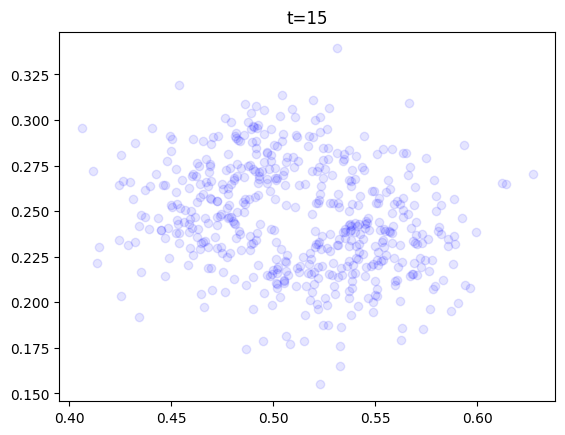

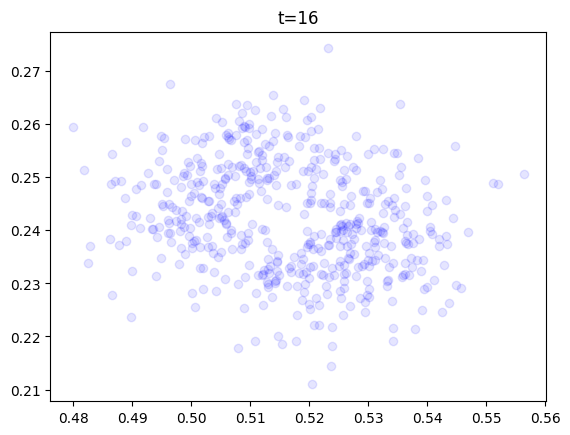

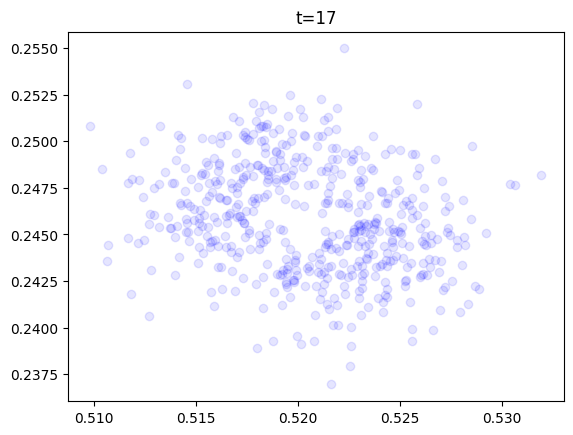

In [76]:
for i, X in enumerate(x_evolution):
    for point in X:
        plt.scatter(point[0], point[1], color='blue', alpha=0.1)
    plt.title(f"t={i}")
    plt.show()

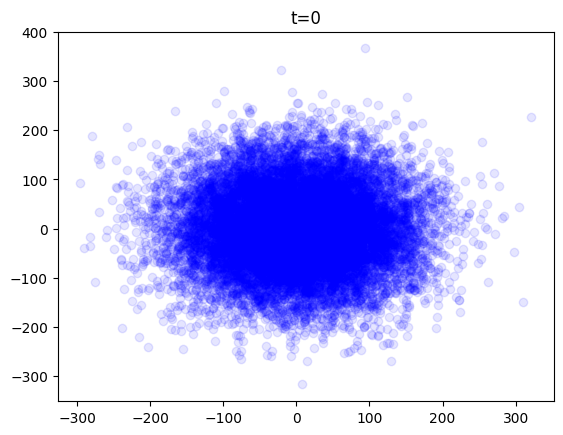

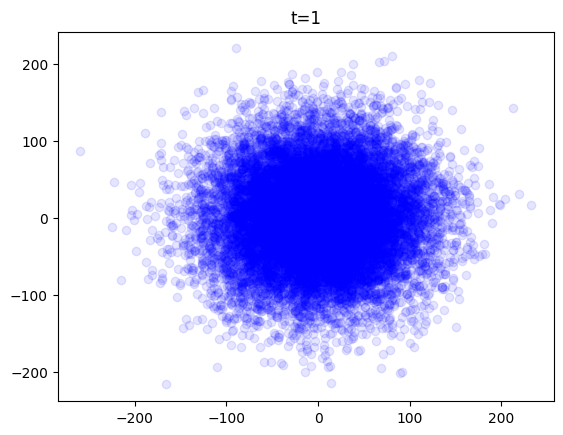

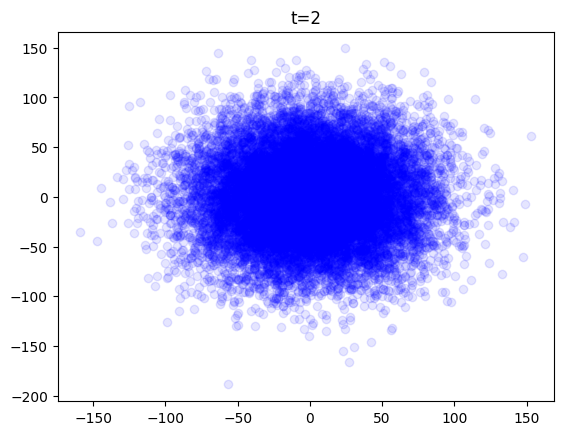

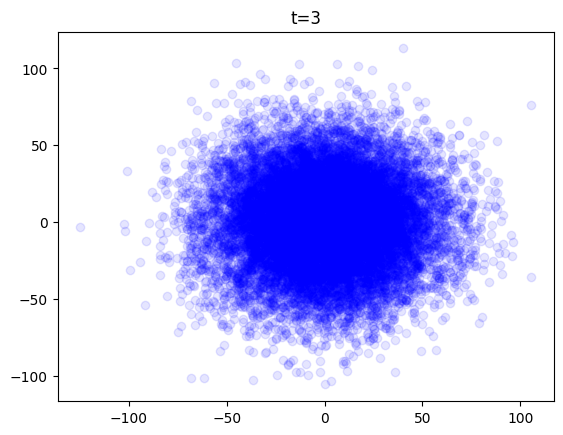

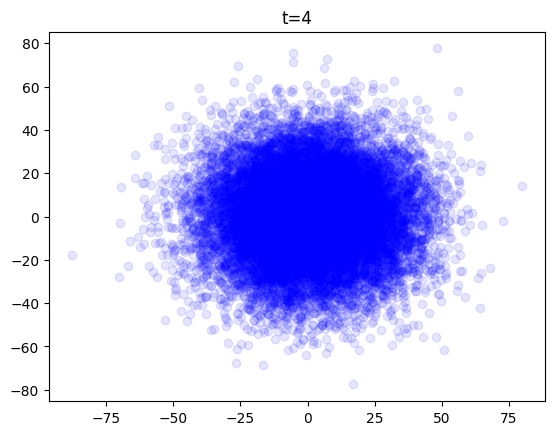

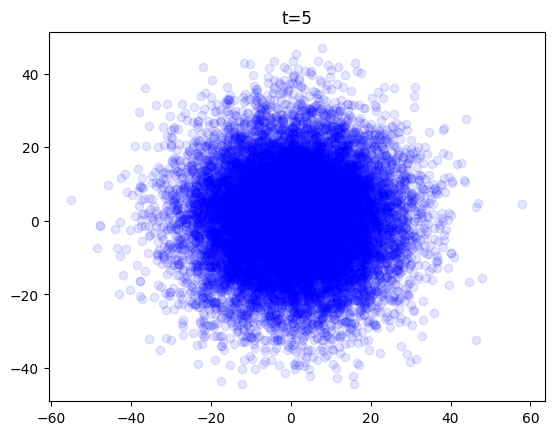

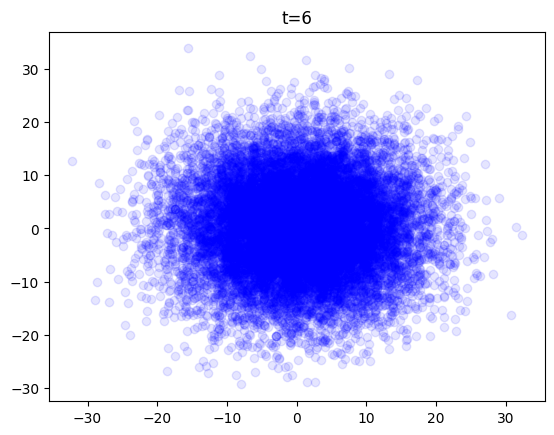

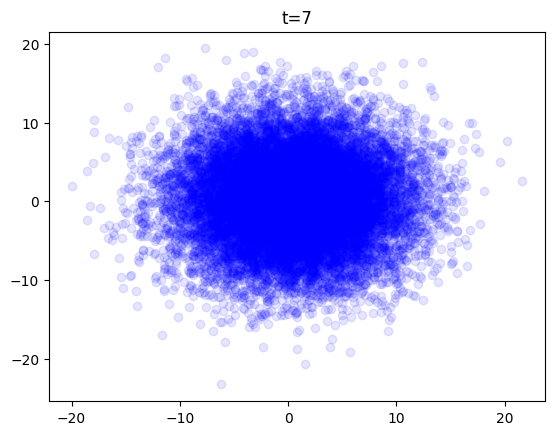

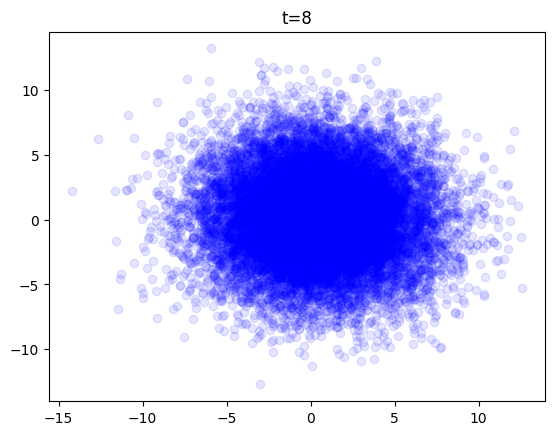

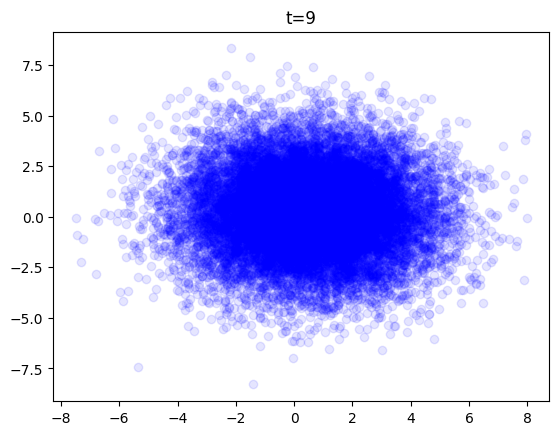

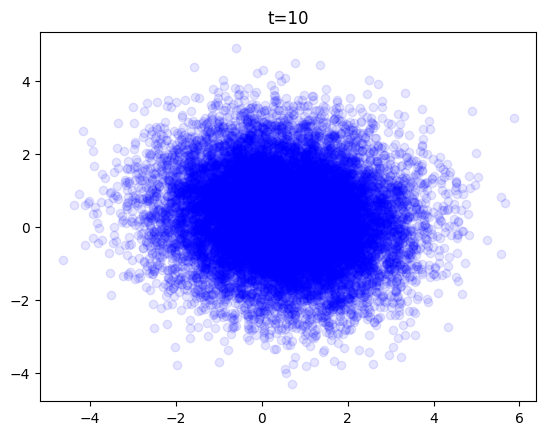

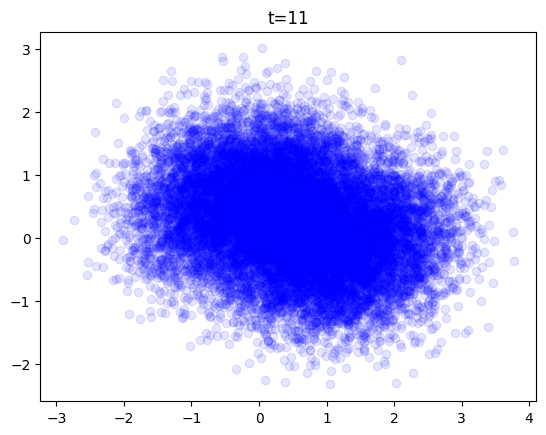

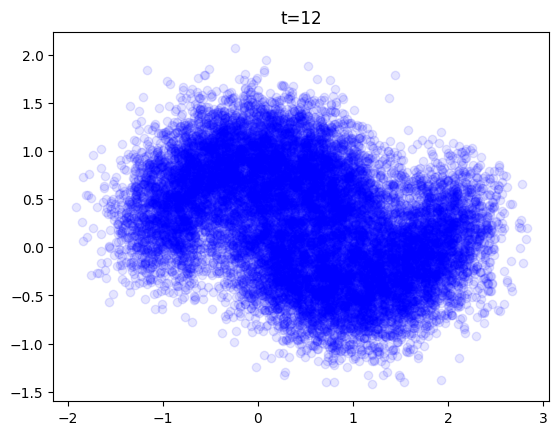

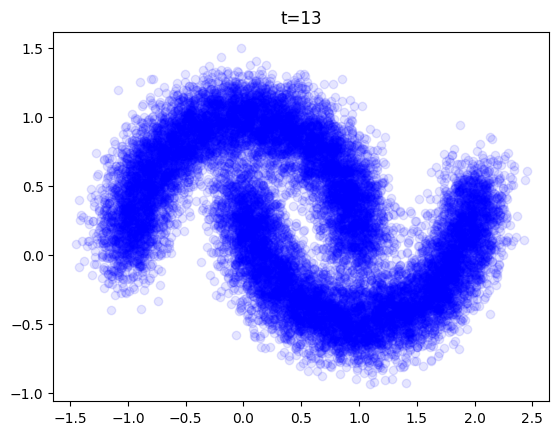

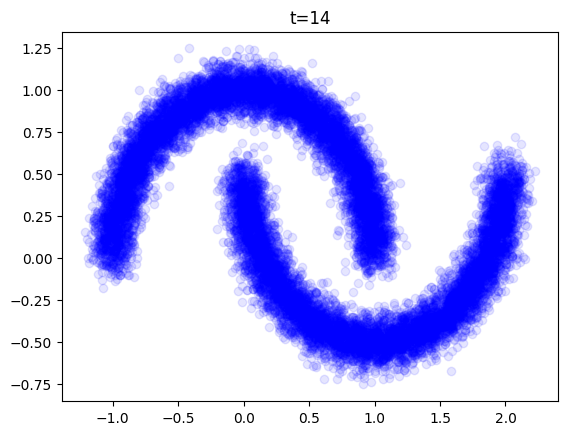

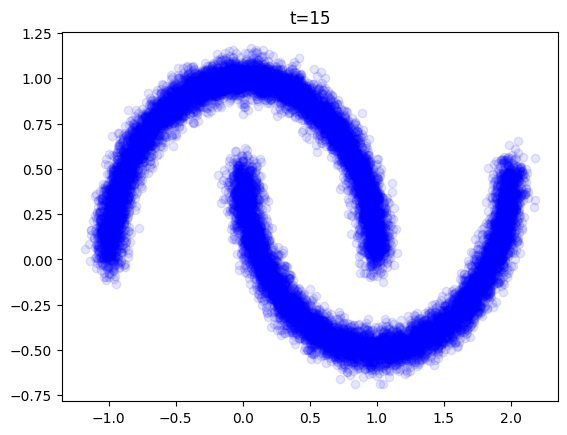

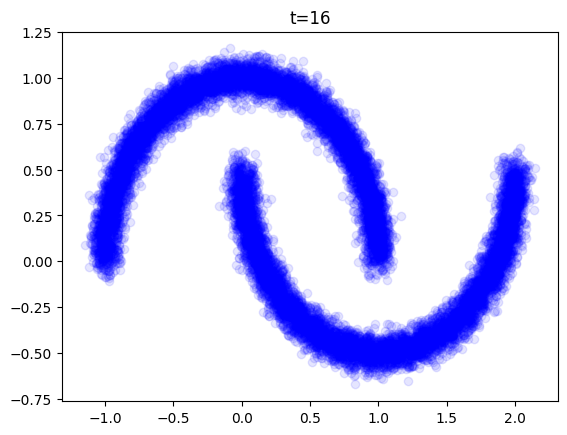

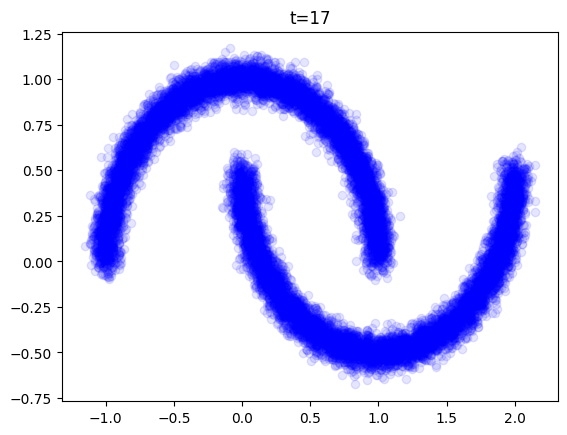

In [77]:
def add_noise_test(dataloader, epsilon=0.002, T=80, rho=7, N=18):
    """
    Training loop for the diffusion model
    """
    batch_size = dataloader.batch_size # Get the batch size of the dataloader
    Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon

    for t in range(len(Ts)):
        X_to_plot = []
        timesteps = torch.full((batch_size,), t, dtype=torch.long) # Create a batched time index
        for X in dataloader:
            X_noisy = X + torch.randn_like(X) * Ts[timesteps][:, None] # Add time-scaled noise to the data
            X_to_plot.append(X_noisy)

        X_to_plot = torch.cat(X_to_plot, dim=0).to("cpu").detach().numpy()
        plt.scatter(X_to_plot[:, 0], X_to_plot[:, 1], color='blue', alpha=0.1)
        plt.title(f"t={t}")
        plt.show()

add_noise_test(dataloader, epsilon, T, rho, N)